In [1]:
import os
import numpy as np
import sys
print(sys.executable)
import tensorflow as tf
from tensorflow.keras import layers, models
import sys
sys.path.insert(1, '../src/')
from config import raw_data_path, univariate_data_path, processed_data_path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


2025-04-10 10:35:35.306042: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


/home/nwertheim/Master-Thesis/thesisenv/bin/python


2025-04-10 10:35:35.321908: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744274135.335815 1293903 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744274135.340042 1293903 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744274135.351745 1293903 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744274135.351762 1293903 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744274135.351763 1293903 computation_placer.cc:177] computation placer alr

In [2]:
save_dir = os.path.join(univariate_data_path, "target_univariate_no_PCA.npy")
target_data = np.load(save_dir, allow_pickle=True)
print(len(target_data))
print(target_data[0])
num_none_preterm = sum(1 for item in target_data if item['preterm'] is None)
print(f"Number of instances with None in 'preterm': {num_none_preterm}")
target_data = [item for item in target_data if item['preterm'] is not None]
print(f"Remaining instances after deletion: {len(target_data)}")
import matplotlib.pyplot as plt
from collections import Counter



1002
{'fs': 20, 'signal': array([-1.70318809, -3.4187089 , -2.48396297, ...,  0.73115951,
        0.40952615,  0.95038211]), 'record_name': 'Hopper-2023_05_25_12_03_38-0000010090-0003-chan0', 'preterm': 0}
Number of instances with None in 'preterm': 144
Remaining instances after deletion: 858


In [3]:
def create_windows(data, window_size):
    windowed_data = []
    for item in data:
        signal = item['signal']
        label = item['preterm']
        record_name = item['record_name']
        
        num_windows = len(signal) // window_size
        for i in range(num_windows):
            start = i * window_size
            end = start + window_size
            window = signal[start:end]
            windowed_data.append({
                'signal': window,
                'label': label,
                'record_name': record_name
            })
    return windowed_data

WINDOW_SIZE = 12000
windowed_data = create_windows(target_data, WINDOW_SIZE)


In [4]:
X = np.stack([d['signal'] for d in windowed_data])
y = np.array([d['label'] for d in windowed_data])
record_names = [d['record_name'] for d in windowed_data]  # for aggregation later
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, rn_train, rn_test = train_test_split(
    X, y, record_names, stratify=y, test_size=0.3, random_state=42
)


In [5]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


In [6]:
from collections import defaultdict, Counter
import numpy as np

# Group predictions by record name
record_pred_dict = defaultdict(list)
record_true_dict = {}

for pred, true, rec in zip(y_pred, y_test, rn_test):
    record_pred_dict[rec].append(pred)
    record_true_dict[rec] = true  # same label for all windows in a record

# Majority vote
final_preds = []
final_truths = []

for rec in record_pred_dict:
    votes = record_pred_dict[rec]
    majority_vote = Counter(votes).most_common(1)[0][0]
    final_preds.append(majority_vote)
    final_truths.append(record_true_dict[rec])


              precision    recall  f1-score   support

           0       0.94      0.21      0.34       287
           1       0.68      0.99      0.80       480

    accuracy                           0.70       767
   macro avg       0.81      0.60      0.57       767
weighted avg       0.77      0.70      0.63       767



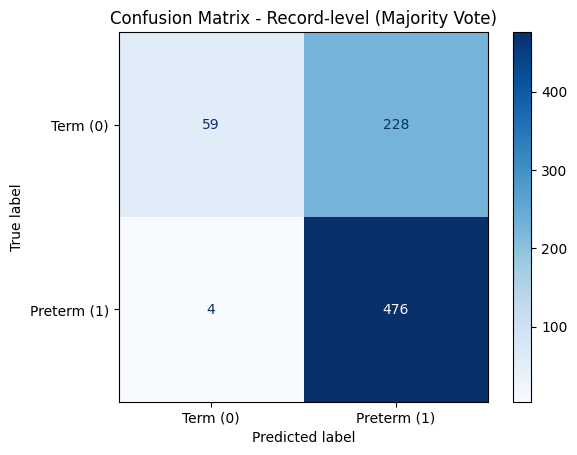

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print(classification_report(final_truths, final_preds))

cm = confusion_matrix(final_truths, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Term (0)", "Preterm (1)"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Record-level (Majority Vote)")
plt.show()
